# Quantum Euclidean Distance for Two Images using Quantum Fourier Transform

In [2]:
#Notebook written by Miguel de Jesús Martínez Felipe and Divyanshu Singh 
# Quantum Euclidean Distance for Two Images using Quantum Fourier Transform
#https://github.com/Miguelillnino and https://github.com/divshacker

from qiskit import *
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy import pi
from qiskit.circuit.library import QFT

#Libraries for Image Processing 
import numpy as np
import cv2
import matplotlib.pyplot as plt

C:\Users\MJMF2\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\MJMF2\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\MJMF2\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %



In this notebook, we will calculate the Euclidean distance with the Quantum Fourier Transform rotation, which can be applied to image processing; we can see an implementation for one pixel and both images.

The topic of similarity/dissimilarity measure can help to solve problems in block matching, and similarity measure. Finding a group of similar image patches inside a search area is essential. In different practical applications often is necessary to find groups of similar image blocks within an ample search area, The problem of image template location in a considered image is very common in different applications such as video compression, image clustering, vector quantization, nonlocal noise reduction; To match templates, various measures of similarity/dissimilarity can be applied.


Given two sequences of measurements $X = {xi : i = 1, . . . , n}$ and $Y = {yi : i = 1, . . . , n}$, the similarity (dissimilarity) between them is a measure that quantifies the dependency (independency) between the sequences. $X$ and $Y$ can represent measurements from two objects or phenomena. So, we assume they represent images and $x_i$ and $y_i$ are intensities of corresponding pixels in the images. If $X$ and $Y$ represent 2-D images, the sequences can be considered intensities in the images in raster-scan order.

A dissimilarity measure $D$ is considered a metric if it produces a higher value as corresponding values in $X$ and $Y$ become less dependent. A metric dissimilarity $D$ satisfies the following for all sequences $X$ and $Y$ [1]:

1. Nonnegativity: $D(X,Y) ≥ 0$.
2. Reflexivity: $D(X,Y) = 0$ if and only if $X = Y$ .
3. Symmetry: $D(X,Y) = D(Y,X)$.
4. Triangle Inequality: $D(X,Y) + D(Y,Z) ≥ D(X,Z)$.

## Square L2 Norm (Euclidean distance)
Square L2 norm, square Euclidean distance, or sum of squared intensity differences of corresponding pixels in sequences $X = {xi : i = 1, . . . , n}$ and $Y = {yi : i = 1, . . . , n}$ is defined by:

\begin{equation}
{L_2^2} = \sum_i^n ({x_i}-{y_i})^2
\end{equation}


## Quantum Fourier Transform

As explained in [2], the Fourier transform occurs in many different versions throughout classical computing, in areas ranging from signal processing to data compression to complexity theory. The quantum Fourier transform (QFT) is the quantum implementation of the discrete Fourier transform over the amplitudes of a wavefunction. It is part of many quantum algorithms, most notably Shor's factoring algorithm and quantum phase estimation.

The Quantum Fourier Transform (QFT) on qubits is the operation:
\begin{equation}
|j\rangle \mapsto \frac{1}{2^{n/2}} \sum_{k=0}^{2^n - 1} e^{2\pi ijk / 2^n} |k\rangle
\end{equation}

For 4 qubits, the circuit that implements this transformation is:

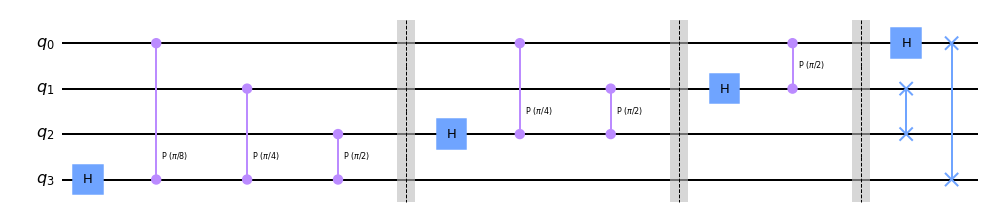

In [3]:
def QFT4qubits(qc):
    qc.h(3)
    qc.cp(pi/8, 0, 3)
    qc.cp(pi/4, 1, 3)
    qc.cp(pi/2, 2, 3)
    qc.barrier()
    qc.h(2)
    qc.cp(pi/4, 0, 2)
    qc.cp(pi/2, 1, 2)
    qc.barrier()
    qc.h(1)
    qc.cp(pi/2, 0, 1)
    qc.barrier()
    qc.h(0)
    qc.swap(0,3)
    qc.swap(1,2)
    
    return qc

qc = QuantumCircuit(4)
QFT4qubits(qc).draw('mpl')

We can see the result in the Fourier state $|˜0⟩$:

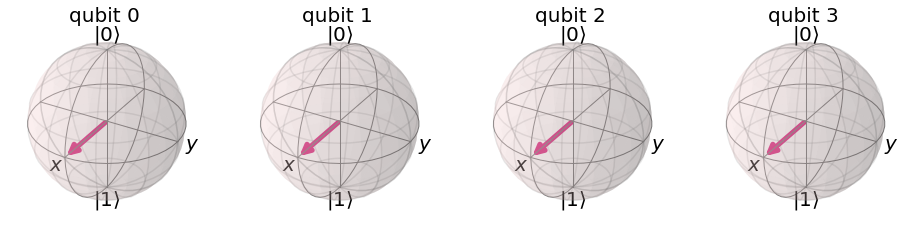

In [4]:
sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(qc)


Adding X-Pauli gates in $q_0$ and $q_3$ for see results in number 9:

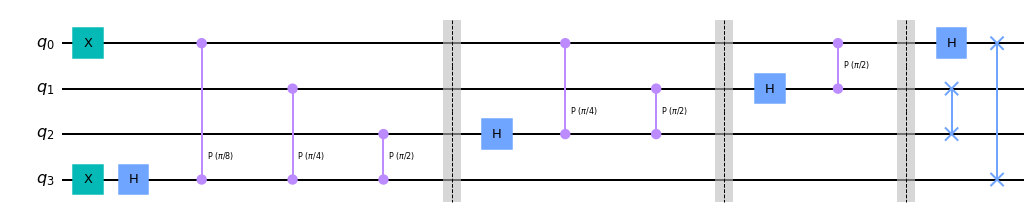

In [5]:
qc = QuantumCircuit(4)
qc.x(0)
qc.x(3)
QFT4qubits(qc).draw('mpl')

We can see the result in the Fourier state $|˜9⟩$:

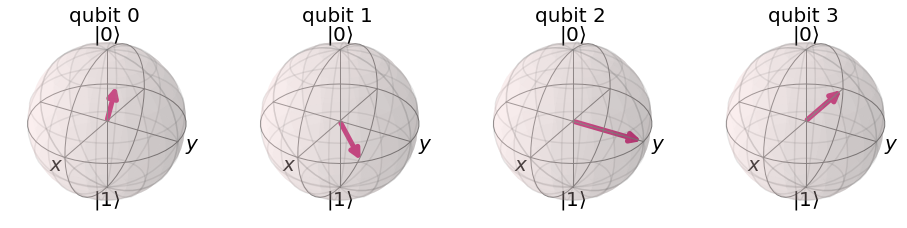

In [6]:
sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(qc)

## Implementation:
For this first example, we need to code the right and left rotations; as we can see, we can perform rotations to the right with the QFT, so when we want to rotate some binary value to the left, so we need to reverse the sign (-) to the rotations.

In [7]:
def add_qubit(qc, q, sign = 1):
    if q > 3:
        sign = -sign
        
    for indx, qb in enumerate(range(8,12)):
        qc.cu1(sign * pi / (2**(3 - indx)), q, qb)
    

To represent one pixel value, it is essential to use four qubits ($q_0,q_1,q_2,q_3$) for the first image pixel, and four qubits ($q_4,q_5,q_6,q_7$) for the second image pixel (remember that $q_0$ and $q_4$ is the most significant value in binary representation), so in this case 4-bit pixel in grey scale are needed for the range of [0,15], and for the last for qubits, we implement the QFT, note that the library qiskit.circuit.library provides the QFT, and we just need to append the circuit.


In [8]:
# For 2 qubits per image
# firstPart = 3
# secondPart = 1
# secondPart = secondPart -2
# firstPart = firstPart - 2

# For 4 qubits per image
# firstPart = 5
# secondPart = 1

def rotationsFourier(qc, sign = 1):
    qc.append(QFT(4), range(8,12))
    qPrima = 0
#   firstPart y secondPart, number of rotations
    firstPart = 5
    secondPart = 1
    for q in range(0,8):
        if q > 3:
            secondPart = secondPart -2
            qPrima = q + secondPart
        else:
            firstPart = firstPart - 2
            qPrima = q + firstPart
#         print(q)
        for index in range(0,2**qPrima):
            add_qubit(qc, q, sign)
            qc.barrier()
   
    qc.append(QFT(4,inverse=True), range(8,12)) #invQFT(4)

In this case, we make an example for one pixel, in the first value $q_0,q_1,q_2,q_3$, 15 is the number represented for the 4-bit  grey scale pixel value. And for $q_4,q_5,q_6,q_7$, 8 is the number represented. You can see the circuit for this example.

<ipython-input-7-3c0fab7e5768>:6: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  qc.cu1(sign * pi / (2**(3 - indx)), q, qb)


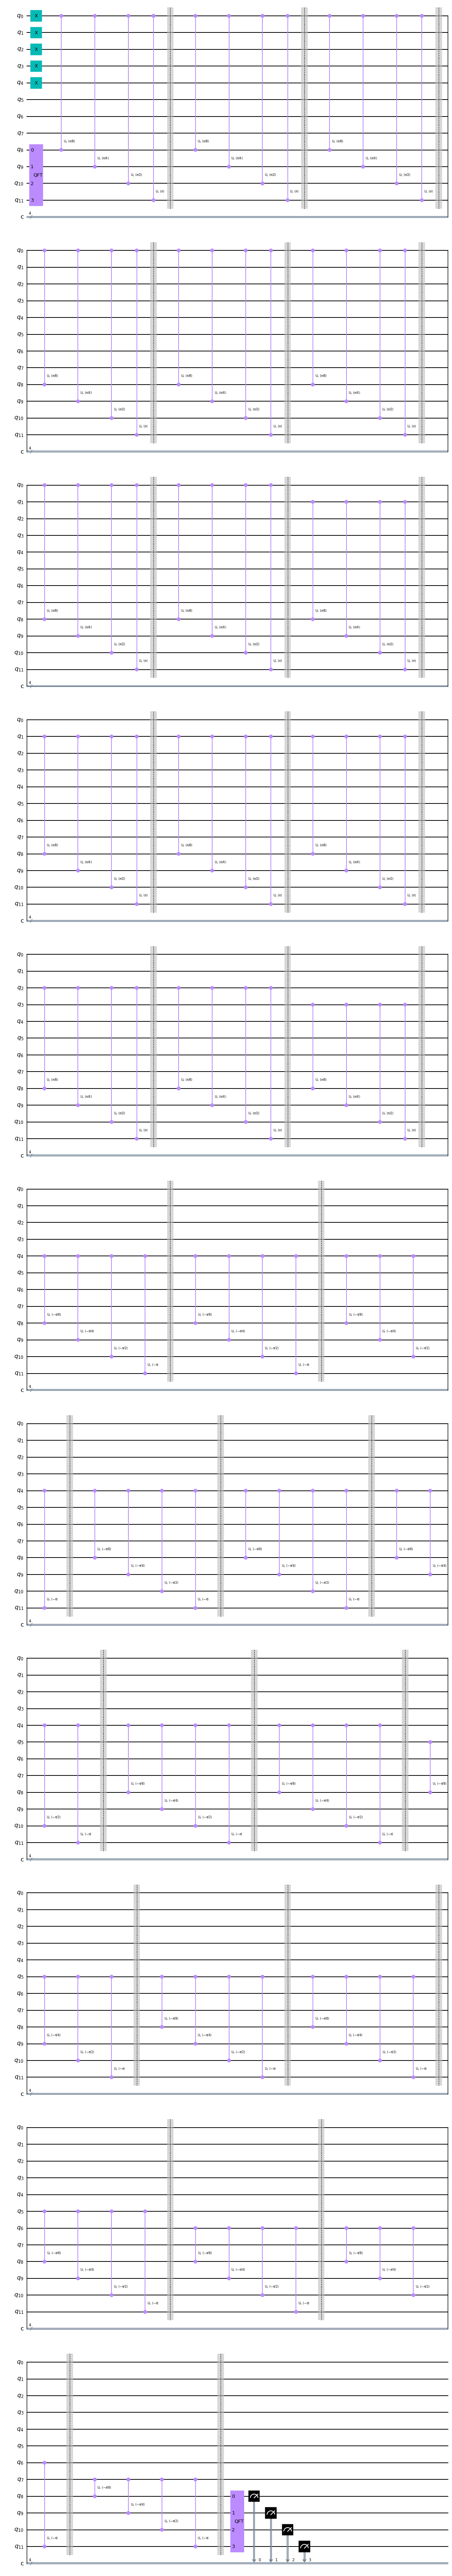

In [9]:
qc = QuantumCircuit(12,4)
# Pixel from the first image
qc.x(0)
qc.x(1)
qc.x(2)
qc.x(3)
# ------------------------------
# ------------------------------
# ------------------------------
# Pixel from the second image
qc.x(4)

rotationsFourier(qc)

qc.measure(range(8,12), range(4))
#qc = qc.reverse_bits()
qc.draw('mpl')

Since we execute the quantum circuit we can see the result in binary value, so '0111' it is the number 7 if we do a conversion to decimal. So we make 15 rotations to the right and eight rotations to the letf, so in this case $15-8=7$

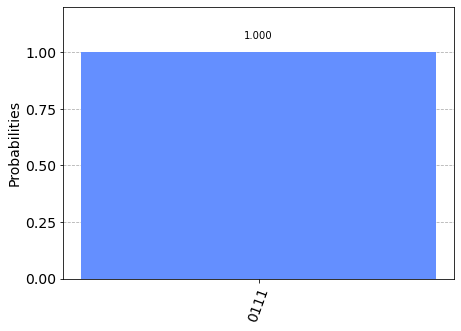

In [10]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots = 5)
plot_histogram(job.result().get_counts())


Now, we can perform our circuit with an actual image; Fistable, it is crucial to have two images, one original image in a grey scale and the same image with some Gaussian nosie, since we want to measure the Euclidean distance between them.

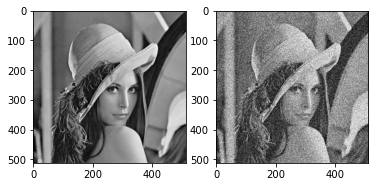

In [11]:
originalImage = cv2.imread('lena_gray.png')
grayOriginalImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
noisyImage = cv2.imread('lena_gray_512_512_variance_400.png')
grayNoisyImage = cv2.cvtColor(noisyImage, cv2.COLOR_BGR2GRAY)
plt.subplot(1,2,1)
plt.imshow(grayOriginalImage, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(grayNoisyImage, cmap='gray')
plt.show()

The second important step it is resized both image from $512\times512$ to $64\times64$ pixels (we can perform the quantum circuit with the original size but it will take too much time)


Original Image Dimensions :  (512, 512)
Resized Original Image Dimensions :  (64, 64)
Resized Noisy Image Dimensions :  (64, 64)


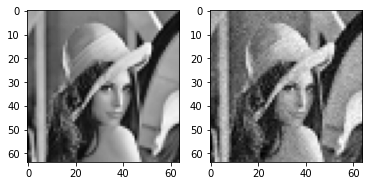

In [12]:
print('Original Image Dimensions : ',grayOriginalImage.shape) # Since images are 512x512 size
scale_percent = 12.5 # percent of original size for a 64x64 size
width = int(grayOriginalImage.shape[1] * scale_percent / 100)
height = int(grayOriginalImage.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize Original image
resizedOriginalImage = cv2.resize(grayOriginalImage, dim, interpolation = cv2.INTER_AREA)
print('Resized Original Image Dimensions : ',resizedOriginalImage.shape)
# resize Noisy image

resizedNoisyImage = cv2.resize(grayNoisyImage, dim, interpolation = cv2.INTER_AREA)
print('Resized Noisy Image Dimensions : ',resizedNoisyImage.shape)


plt.subplot(1,2,1)
plt.imshow(resizedOriginalImage, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(resizedNoisyImage, cmap='gray')
plt.show()

The next step is to reduce the 8-bit pixel to 4-bit pixel, since we have an image of 8-bit pixel, making 256 rotations it not will be an option for a quantum circuit (this for the time consuming), for the 4-bit pixel, we can divide each value of the pixel by 17 from the 64x64 image.

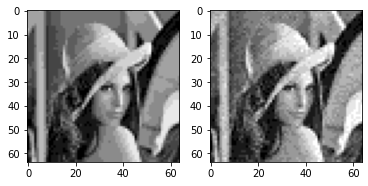

In [13]:
[hight,lenght] = resizedOriginalImage.shape

#Build an array for the original image 64*64
arrayOriginalImage = np.arange(0, 4096, 1, np.uint8)
arrayOriginalImage = np.reshape(arrayOriginalImage, (64, 64))

#CBuild an array for the noisy image de 64*64
arrayNoisyImage = np.arange(0, 4096, 1, np.uint8)
arrayNoisyImage = np.reshape(arrayNoisyImage, (64, 64))

for altura in range(0,hight):
    for ancho in range (0,lenght):
        arrayOriginalImage[altura,ancho] = int(resizedOriginalImage[altura,ancho]/17)
        arrayNoisyImage[altura,ancho] = int(resizedNoisyImage[altura,ancho]/17)        
        
plt.subplot(1,2,1)
plt.imshow(arrayOriginalImage, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(arrayNoisyImage, cmap='gray')
plt.show()

After having our images in the desired format, the next step it is to measures the result of each pixel performed in the quantum circuit. Since we have, nevertheless, it is essential to complete all the binaries values, because if we have a number '0011' when we convert the number, the result will be '11', so it is necessary to complete the string form of the binary value for the four qubits

In [11]:
def completeStringValue(longValue,strignValue):
    resta = longValue - len(strignValue)
    Ceros = ''
    if resta !=0:
        for i in range(0,resta):
            Ceros += '0'      
    return Ceros+strignValue

There is one condition to take into account, when we have a pixel value in our first image that is greater than the second pixel value example: $0101 - 0110$ the result will be $1111$ but in decimal numbers $5 - 6 = -1$. And '1111' (binary) $\neq$ 1 (decimal) , so we consider the negative binary number as a complement, in this case for 4-bit pixel:

-1111 = -1

-1110 = -2

$\vdots$

-0010 = -14

-0001 = -15

In [12]:
listaCircuits = []
for i in range (0,arrayOriginalImage.shape[0]):
    for j in range (0,arrayOriginalImage.shape[1]):
        binaryPixelOne = bin(int(arrayOriginalImage[i,j]))
        binaryPixelTwo = bin(int(arrayNoisyImage[i,j]))
        CompleteBinaryOne = completeStringValue(4,binaryPixelOne[2:len(binaryPixelOne)])
        CompleteBinaryTwo = completeStringValue(4,binaryPixelTwo[2:len(binaryPixelTwo)])
        valueBinaryOne = str(CompleteBinaryOne)
        valueBinaryOTwo = str(CompleteBinaryTwo)

# Pixeles from Fisrt Image
# ------------------------------
# ------------------------------
# ------------------------------
# ------------------------------
        qc = QuantumCircuit(13,5)
        for idx, px_value in enumerate(valueBinaryOne[::1]):
            if(px_value=='1'):
                qc.x(idx)
                
# Pixels from Second Image
# ------------------------------
# ------------------------------
# ------------------------------
# ------------------------------

        for idy, py_value in enumerate(valueBinaryOTwo[::1]):
            if(py_value=='1'):
                qc.x(idy+4)
        rotationsFourier(qc)
####
#### Condition for negative numbers
####
        if (int(arrayOriginalImage[i,j]) < int(arrayNoisyImage[i,j])) and (int(arrayOriginalImage[i,j]) - int(arrayNoisyImage[i,j]) != 0) :
            qc.x(12)
        qc.measure(range(8,13), range(5))
        listaCircuits.append(qc)
#qc.draw()

In [14]:
backend = Aer.get_backend('qasm_simulator')
job = execute(listaCircuits, backend, shots = 5)
# plot_histogram(job.result().get_counts())

The last step after appending  all the values in a list of circuits and execute the circuits in order to get the counts we need to compare our result with the classical part. In this case after converting the binray number, remember that for the negative binary numbers we need to make a complement, in this case we did a condition if there is a negative binary number we use a qubit to make a flag for identifying all the negative binary numbers, in this case we execute the X-Pauli gate in the circuit. So when we get that number we only rest the complement from 16 to get the right value.

In [15]:
distance = 0
result_submissions = job.result()
for qc in listaCircuits:
    counts = result_submissions.get_counts(qc)
    number= list(counts)[0]
    if number[0] == '0':
        dec_number= int(number, 2)
    else:
        dec_number= int(number[1:len(number)], 2) - 16

    distance += (dec_number**2)
print(distance)

1235


In [16]:
dist = 0
for i in range(0,arrayOriginalImage.shape[0]):
    for j in range(0,arrayOriginalImage.shape[0]):
        number = (int(arrayOriginalImage[i,j])-int(arrayNoisyImage[i,j]))
        dist += number**2

dist

1235

## References:

[1] Goshtasby, A. Ardeshir. Image registration: Principles, tools and methods. Springer Science & Business Media, 2012.

[2] https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html

[3] M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000).